In [154]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

#2020 population of Catalonia from https://www.idescat.cat/pub/?id=aec&n=245
popCatalunya = 7722203

#Catalonia's health department data https://dadescovid.cat/descarregues
resp = urlopen("https://dadescovid.cat/static/csv/catalunya_diari_total_pob.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = zipfile.namelist()[0]
df = pd.read_csv(zipfile.open(file), sep=";")
df.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,CATALUNYA,GLOBAL,2021-02-11,Altres,NaN,16,139,10,0,0,...,32,0,6,10,3,2,134,9,7,5
1,CATALUNYA,GLOBAL,2021-02-11,Dona,Entre 15 i 64,293,893,4949,1,3,...,59,1,13,280,10,171,800,4590,5927,2983
2,CATALUNYA,GLOBAL,2021-02-11,Dona,Entre 65 i 74,30,46,335,0,0,...,50,0,4,26,4,23,44,324,23,64
3,CATALUNYA,GLOBAL,2021-02-11,Dona,Majors de 74,40,150,234,0,0,...,26,1,3,37,3,24,129,207,58,342
4,CATALUNYA,GLOBAL,2021-02-11,Dona,Menors de 15,39,79,385,0,0,...,0,0,6,33,5,18,73,377,0,0


**Check if new data has been added to the source file**

In [155]:
previousdf_columns = ['NOM',
 'CODI',
 'DATA',
 'SEXE',
 'GRUP_EDAT',
 'CASOS_CONFIRMAT',
 'PCR',
 'TAR',
 'INGRESSOS_TOTAL',
 'INGRESSOS_CRITIC',
 'INGRESSATS_TOTAL',
 'INGRESSATS_CRITIC',
 'EXITUS',
 'CASOS_PCR',
 'CASOS_TAR',
 'POSITIVITAT_PCR_NUM',
 'POSITIVITAT_TAR_NUM',
 'POSITIVITAT_PCR_DEN',
 'POSITIVITAT_TAR_DEN',
 'VACUNATS_DOSI_1',
 'VACUNATS_DOSI_2']
assert list(df.columns) == previousdf_columns, "Source data has changed format"

In [156]:
df["DATA"] = pd.to_datetime(df["DATA"])
dfagg = df.groupby("DATA").agg(sum)
dfagg.tail()

,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
DATA,,,,,,,,,,,,,,,,
2021-02-07,572,5217,3818,123,36,2768,584,51,217,355,211,326,4685,3538,257,681
2021-02-08,2418,29391,19425,169,27,2650,566,56,1154,1264,1170,1372,26414,18025,2268,7521
2021-02-09,1884,35857,22242,163,42,2573,565,48,1000,884,1203,945,32057,20708,3066,9242
2021-02-10,1235,23467,21787,145,32,2476,560,37,490,745,573,755,20580,20268,9789,5671
2021-02-11,767,2025,10205,4,22,2389,537,2,58,709,45,423,1807,9583,11706,4775


**Date of first vaccination recorded**

In [157]:
first_vaccination_date=min(dfagg.index[dfagg.VACUNATS_DOSI_1>0])
first_vaccination_date

Timestamp('2020-12-27 00:00:00')

In [158]:
dfaggvac = dfagg[dfagg.index>=first_vaccination_date]
dfaggvac.reset_index(inplace=True)
dfaggvac['Weekend'] = np.where(dfaggvac["DATA"].dt.weekday < 5,0,1)
dfaggvac["1st dose percent"] = dfaggvac["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
dfaggvac["2nd dose percent"] = dfaggvac["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfaggvac.head()

,DATA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
0,2020-12-27,1131,4999,4121,169,33,1788,326,42,404,727,331,573,4620,3896,803,0,1,0.010399,0.0
1,2020-12-28,4029,21868,19984,255,37,1833,339,47,1415,2614,1239,2377,19554,18552,1,0,0,0.010412,0.0
2,2020-12-29,3979,26524,19710,249,25,1850,339,44,1546,2433,1495,2301,23814,18180,447,0,0,0.016200,0.0
3,2020-12-30,3778,27743,19710,236,25,1835,333,47,1499,2279,1532,2232,24741,18467,2585,0,0,0.049675,0.0
4,2020-12-31,3410,22490,17236,234,38,1803,345,47,1448,1962,1627,2007,20150,16189,2591,0,0,0.083228,0.0


In [159]:
tidy = dfaggvac[["DATA","VACUNATS_DOSI_1","VACUNATS_DOSI_2"]]
tidy.columns = ["DATA","1st","2nd"]
tidy = tidy.melt(id_vars="DATA",ignore_index = False).rename(columns=str.title)
tidy.rename(columns = {'Variable': 'Dose'} , inplace=True)
tidy['Data'] = tidy['Data'].dt.strftime('%d-%b')

In [160]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
sns.set_style('white')
dmax = max(dfaggvac["DATA"]) + pd.DateOffset(1)
dmin = min(dfaggvac["DATA"]) - pd.DateOffset(1)

Extrapolate from last week number of vaccinations, when will all the Catalan population be vaccinated

In [161]:
import datetime
lastweek = dfaggvac.tail(7)
vaccperday = np.sum(lastweek["VACUNATS_DOSI_2"])/7
nonvaccinated = popCatalunya*(1 -  lastweek.loc[lastweek.index[-1], "2nd dose percent"] /100) 
days_to_end_vaccination = nonvaccinated/vaccperday
vaccination_end = (max(dfaggvac["DATA"]) + datetime.timedelta(days=days_to_end_vaccination)).strftime("%Y-%m-%d")

<IPython.core.display.Javascript object>


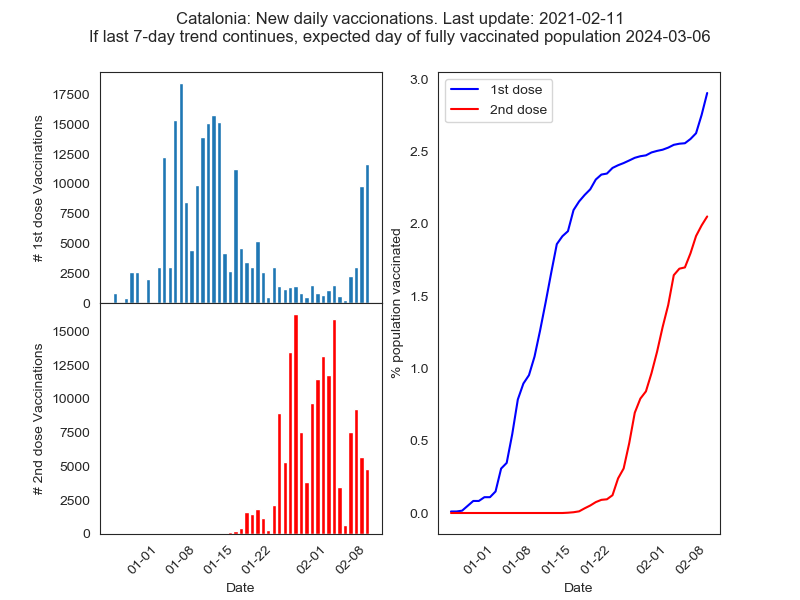

In [162]:
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2,2)

date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
fig.suptitle("Catalonia: New daily vaccionations. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d") +
            "\nIf last 7-day trend continues, expected day of fully vaccinated population " + vaccination_end)

# Defining custom 'xlim' and 'ylim' values.
maxx = max(dfaggvac["VACUNATS_DOSI_1"].max(),dfaggvac["VACUNATS_DOSI_2"].max())
custom_ylim = (0, maxx+1000)

# Setting the values for all axes.
#plt.setp(ax1, ylim=custom_ylim)

ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(x="DATA", height="VACUNATS_DOSI_1",data=dfaggvac)
ax1.set_ylabel("# 1st dose Vaccinations")
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

ax2 = fig.add_subplot(gs[1, 0]) 

ax2.bar(x="DATA", height="VACUNATS_DOSI_2",data=dfaggvac, color="red")
ax2.set_xlabel("Date")
ax2.set_ylabel("# 2nd dose Vaccinations")
ax2.xaxis.set_major_formatter(date_form)
ax2.tick_params(axis="x",rotation=45)

ax3 = fig.add_subplot(gs[:, 1])

ax3.plot(dfaggvac["DATA"], dfaggvac["1st dose percent"], color="blue", label="1st dose")
ax3.plot(dfaggvac["DATA"], dfaggvac["2nd dose percent"], color="red", label="2nd dose")

ax3.set_xlabel("Date")
ax3.set_ylabel("% population vaccinated")
ax3.xaxis.set_major_formatter(date_form)
ax3.legend()
ax3.tick_params(axis="x",rotation=45)

plt.show()
plt.savefig('CurrentOverallVaccinationCat.png')

<IPython.core.display.Javascript object>


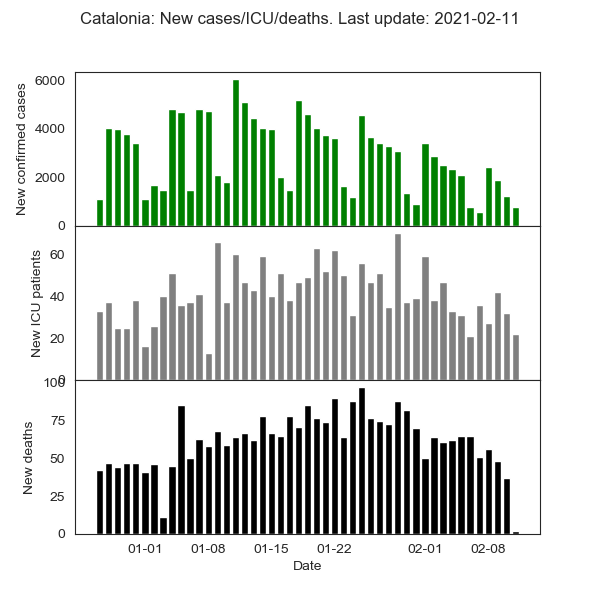

In [163]:
fig3, ax3 = plt.subplots(3,1,figsize=(6, 6), sharex=True)
date_form = DateFormatter("%m-%d")
# Remove horizontal space between axes
fig3.subplots_adjust(hspace=0)
fig3.suptitle("Catalonia: New cases/ICU/deaths. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d"))

ax3[0].bar(x="DATA", height="CASOS_CONFIRMAT",data=dfaggvac, color="green")
ax3[0].set_ylabel("New confirmed cases")

ax3[1].bar(x="DATA", height="INGRESSOS_CRITIC",data=dfaggvac, color="grey")
ax3[1].set_ylabel("New ICU patients")

ax3[2].bar(x="DATA", height="EXITUS",data=dfaggvac, color="black")
ax3[2].set_xlabel("Date")
ax3[2].set_ylabel("New deaths")
ax3[2].xaxis.set_major_formatter(date_form)

plt.show()
plt.savefig('CurrentCasesICUDeathsCat.png')

In [164]:
dfage = df.groupby(["DATA","GRUP_EDAT"]).agg(sum)
dfage.head()
#Població per sexe i grups d'edat: https://www.idescat.cat/pub/?id=aec&n=253


CASOS_CONFIRMAT  PCR  TAR  INGRESSOS_TOTAL  \
DATA       GRUP_EDAT                                                   
2020-03-01 Entre 15 i 64                1   12    0                0   
           Entre 65 i 74                0    4    0                0   
           Majors de 74                 0    4    0                0   
           Menors de 15                 0    0    0                0   
2020-03-02 Entre 15 i 64                4   26    0                0   

                          INGRESSOS_CRITIC  INGRESSATS_TOTAL  \
DATA       GRUP_EDAT                                           
2020-03-01 Entre 15 i 64                 0                 0   
           Entre 65 i 74                 0                 0   
           Majors de 74                  0                 0   
           Menors de 15                  0                 0   
2020-03-02 Entre 15 i 64                 0                 0   

                          INGRESSATS_CRITIC  EXITUS  CASOS_PCR  CASOS_TAR  \
DATA       GRUP_EDAT                                                        
2020-03-01 Entre 15 i 64                  0       0          1          0   
           Entre 65 i 74                  0       0          0          0   
           Majors de 74                   0       0          0          0   
           Menors de 15                   0       0          0          0   
2020-03-02 Entre 15 i 64                  0       0          4          0   

                          POSITIVITAT_PCR_NUM  POSITIVITAT_TAR_NUM  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                    0                    0   
           Entre 65 i 74                    0                    0   
           Majors de 74                     0                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                    2                    0   

                          POSITIVITAT_PCR_DEN  POSITIVITAT_TAR_DEN  \
DATA       GRUP_EDAT                                                 
2020-03-01 Entre 15 i 64                   12                    0   
           Entre 65 i 74                    4                    0   
           Majors de 74                     4                    0   
           Menors de 15                     0                    0   
2020-03-02 Entre 15 i 64                   26                    0   

                          VACUNATS_DOSI_1  VACUNATS_DOSI_2  
DATA       GRUP_EDAT                                        
2020-03-01 Entre 15 i 64                0                0  
           Entre 65 i 74                0                0  
           Majors de 74                 0                0  
           Menors de 15                 0                0  
2020-03-02 Entre 15 i 64                0                0

In [165]:
#Downloaded from https://www.idescat.cat/pub/?id=aec&n=253
popdf = pd.read_html("aec-253.xls")
popdf = popdf[0]
popdf = popdf[:-4]
popdf = popdf[["Unnamed: 0", "Homes", "Dones", "Total"]]
popdf.rename(columns={"Unnamed: 0":"Age range", "Homes" : "Men", "Dones":"Women"},inplace=True)
popdf.replace({'\.':''}, regex=True,inplace=True)
popdf = popdf.astype({'Men': 'int64','Women': 'int64','Total': 'int64'})
popdf

,Age range,Men,Women,Total
0,De 0 a 4 anys,177639,168224,345863
1,De 5 a 9 anys,207060,194449,401509
2,De 10 a 14 anys,223267,208376,431643
3,De 15 a 19 anys,210527,193260,403787
4,De 20 a 24 anys,205008,191087,396095
5,De 25 a 29 anys,221110,216044,437154
6,De 30 a 34 anys,231001,235104,466105
7,De 35 a 39 anys,270896,274488,545384
8,De 40 a 44 anys,334557,325651,660208
9,De 45 a 49 anys,324031,313261,637292


In [166]:
popranges = np.sum(popdf.loc[0:3,"Total"]), np.sum(popdf.loc[3:13,"Total"]), np.sum(popdf.loc[13:15,"Total"]),np.sum(popdf.loc[15:,"Total"])
popranges = pd.Series(popranges,index=['Menors de 15','Entre 15 i 64', 'Entre 65 i 74', 'Majors de 74'])
popranges

Menors de 15     1582802
Entre 15 i 64    5462530
Entre 65 i 74    1016572
Majors de 74      725118
dtype: int64

In [167]:
dfage.reset_index(inplace=True)
dfage

,DATA,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,2020-03-01,Entre 15 i 64,1,12,0,0,0,0,0,0,1,0,0,0,12,0,0,0
1,2020-03-01,Entre 65 i 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
2,2020-03-01,Majors de 74,0,4,0,0,0,0,0,0,0,0,0,0,4,0,0,0
3,2020-03-01,Menors de 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-02,Entre 15 i 64,4,26,0,0,0,0,0,0,4,0,2,0,26,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,2021-02-10,Menors de 15,170,2778,1744,1,0,2,0,0,95,75,110,77,2679,1702,0,0
1388,2021-02-11,Entre 15 i 64,548,1354,8338,1,11,786,215,1,31,517,24,312,1203,7809,11526,4195
1389,2021-02-11,Entre 65 i 74,53,119,598,1,8,584,198,0,5,48,5,37,110,573,92,131
1390,2021-02-11,Majors de 74,67,256,433,2,3,877,92,1,5,62,5,36,215,389,81,444


In [168]:
dfage = dfage[dfage.DATA>=first_vaccination_date]
aggAgedf = []
for x in popranges.index:
    x1 = dfage[dfage.GRUP_EDAT==x]
    x1["1st dose percent"] =  x1["VACUNATS_DOSI_1"].cumsum()/popranges[x]*100
    x1["2nd dose percent"] =  x1["VACUNATS_DOSI_2"].cumsum()/popranges[x]*100
    
    aggAgedf.append(x1)

<IPython.core.display.Javascript object>


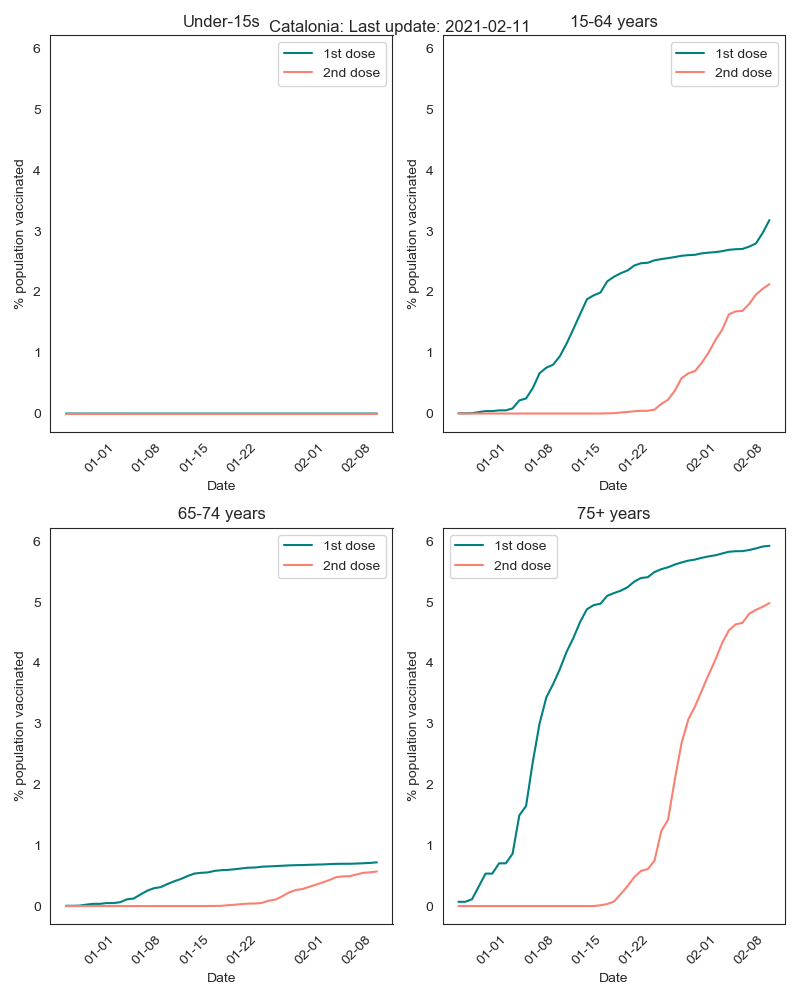

In [169]:
fig = plt.figure(figsize=(8, 10))
fig.suptitle("Catalonia: Last update: " + max(aggAgedf[0]["DATA"]).strftime("%Y-%m-%d"))

gs = fig.add_gridspec(2,2)


ax = fig.add_subplot(gs[0, 0])
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[0]["DATA"], aggAgedf[0]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("Under-15s")


ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[1]["DATA"], aggAgedf[1]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("15-64 years")


ax = fig.add_subplot(gs[1, 0], sharey=ax)
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[2]["DATA"], aggAgedf[2]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("65-74 years")


ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["1st dose percent"], color="teal", label="1st dose")
ax.plot(aggAgedf[3]["DATA"], aggAgedf[3]["2nd dose percent"], color="salmon", label="2nd dose")
ax.set_xlabel("Date")
ax.set_ylabel("% population vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
ax.title.set_text("75+ years")
gs.tight_layout(fig)

plt.show()
plt.savefig('CurrentByAgeVaccinationCat.png')

**Data by region**

In [170]:
#https://dadescovid.cat/static/csv/regio_diari_total_pob.zip
#Catalonia's health department data https://dadescovid.cat/descarregues
resp = urlopen("https://dadescovid.cat/static/csv/regio_diari_total_pob.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = zipfile.namelist()[0]
dfreg = pd.read_csv(zipfile.open(file), sep=";")
dfreg.head()

,NOM,CODI,DATA,SEXE,GRUP_EDAT,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,...,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
0,ALT PIRINEU I ARAN,71,2021-02-11,Dona,Entre 15 i 64,5,3,77,0,0,...,0,0,0,5,0,2,3,68,32,7
1,ALT PIRINEU I ARAN,71,2021-02-11,Dona,Entre 65 i 74,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
2,ALT PIRINEU I ARAN,71,2021-02-11,Dona,Majors de 74,1,3,15,0,0,...,0,0,0,1,0,1,3,5,0,5
3,ALT PIRINEU I ARAN,71,2021-02-11,Dona,Menors de 15,0,0,3,0,0,...,0,0,0,0,0,0,0,3,0,0
4,ALT PIRINEU I ARAN,71,2021-02-11,Home,Entre 15 i 64,4,1,39,0,0,...,1,0,2,2,0,1,1,34,150,1


In [171]:
regions = dfreg["NOM"].unique()
dfreg["DATA"] = pd.to_datetime(dfreg["DATA"])
dfreg = dfreg[dfreg.DATA>=first_vaccination_date]
dfregagg = dfreg.groupby(["NOM","DATA"]).agg(sum)
dfregagg.head()

CODI  CASOS_CONFIRMAT  PCR  TAR  \
NOM                DATA                                          
ALT PIRINEU I ARAN 2020-12-27   568               15   52   31   
                   2020-12-28   568               39  285  163   
                   2020-12-29   568               59  218  195   
                   2020-12-30   568               45  141  260   
                   2020-12-31   568               78  360  192   

                               INGRESSOS_TOTAL  INGRESSOS_CRITIC  \
NOM                DATA                                            
ALT PIRINEU I ARAN 2020-12-27                3                 1   
                   2020-12-28                7                 2   
                   2020-12-29                0                 0   
                   2020-12-30                3                 0   
                   2020-12-31                4                 1   

                               INGRESSATS_TOTAL  INGRESSATS_CRITIC  EXITUS  \
NOM                DATA                                                      
ALT PIRINEU I ARAN 2020-12-27                18                  5       0   
                   2020-12-28                22                  7       0   
                   2020-12-29                23                  7       0   
                   2020-12-30                24                  7       0   
                   2020-12-31                23                  6       1   

                               CASOS_PCR  CASOS_TAR  POSITIVITAT_PCR_NUM  \
NOM                DATA                                                    
ALT PIRINEU I ARAN 2020-12-27          6          9                    5   
                   2020-12-28         19         20                   18   
                   2020-12-29         15         44                   16   
                   2020-12-30         14         31                   12   
                   2020-12-31         28         50                   38   

                               POSITIVITAT_TAR_NUM  POSITIVITAT_PCR_DEN  \
NOM                DATA                                                   
ALT PIRINEU I ARAN 2020-12-27                    8                   43   
                   2020-12-28                   14                  243   
                   2020-12-29                   44                  172   
                   2020-12-30                   30                  124   
                   2020-12-31                   46                  324   

                               POSITIVITAT_TAR_DEN  VACUNATS_DOSI_1  \
NOM                DATA                                               
ALT PIRINEU I ARAN 2020-12-27                   27               80   
                   2020-12-28                  159                0   
                   2020-12-29                  185               48   
                   2020-12-30                  243               93   
                   2020-12-31                  189              107   

                               VACUNATS_DOSI_2  
NOM                DATA                         
ALT PIRINEU I ARAN 2020-12-27                0  
                   2020-12-28                0  
                   2020-12-29                0  
                   2020-12-30                0  
                   2020-12-31                0

In [172]:
regions

array(['ALT PIRINEU I ARAN', 'BARCELONA CIUTAT', 'CAMP DE TARRAGONA',
       'CATALUNYA CENTRAL', 'GIRONA', 'LLEIDA', 'METROPOLITANA NORD',
       'METROPOLITANA SUD', "TERRES DE L'EBRE"], dtype=object)

#Population data from https://catsalut.gencat.cat/web/.content/minisite/catsalut/proveidors_professionals/registres_catalegs/documents/poblacio-referencia.pdf

**Regions sanitàries Població**

Alt Pirineu i Aran 67.277

Lleida 362.850

Camp de Tarragona 607.999

Terres de l'Ebre 176.817

Girona 861.753

Catalunya Central 526.959

Barcelona 5.050.190

    Àmbit Territorial Barcelona Ciutat 1.693.449
    Àmbit Territorial Metropolità Nord 1.986.032
    Àmbit Territorial Metropolità Sud 1.370.709

Total Catalunya 7.653.845

In [173]:
popregions = pd.Series([67277, 1693449,607999,526959,861753,362850,1986032,1370709,176817],index=regions)
popregions

ALT PIRINEU I ARAN      67277
BARCELONA CIUTAT      1693449
CAMP DE TARRAGONA      607999
CATALUNYA CENTRAL      526959
GIRONA                 861753
LLEIDA                 362850
METROPOLITANA NORD    1986032
METROPOLITANA SUD     1370709
TERRES DE L'EBRE       176817
dtype: int64

In [174]:
dfregagg.reset_index(inplace=True)
dfregagg.set_index("NOM",inplace=True)
dfregagg

,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2
NOM,,,,,,,,,,,,,,,,,,
ALT PIRINEU I ARAN,2020-12-27,568,15,52,31,3,1,18,5,0,6,9,5,8,43,27,80,0
ALT PIRINEU I ARAN,2020-12-28,568,39,285,163,7,2,22,7,0,19,20,18,14,243,159,0,0
ALT PIRINEU I ARAN,2020-12-29,568,59,218,195,0,0,23,7,0,15,44,16,44,172,185,48,0
ALT PIRINEU I ARAN,2020-12-30,568,45,141,260,3,0,24,7,0,14,31,12,30,124,243,93,0
ALT PIRINEU I ARAN,2020-12-31,568,78,360,192,4,1,23,6,1,28,50,38,46,324,189,107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TERRES DE L'EBRE,2021-02-07,504,10,45,113,1,0,71,25,2,2,8,2,6,40,112,3,70
TERRES DE L'EBRE,2021-02-08,504,25,765,320,4,0,68,25,0,10,15,8,21,711,304,53,10
TERRES DE L'EBRE,2021-02-09,504,16,705,473,4,0,66,24,2,5,11,7,12,647,452,151,228


In [175]:
dfregagg['Weekend'] = np.where(dfregagg["DATA"].dt.weekday < 5,0,1)
dfregagg['1st dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_1'].transform(pd.Series.cumsum)
dfregagg['2nd dose percent'] = dfregagg.groupby("NOM")['VACUNATS_DOSI_2'].transform(pd.Series.cumsum)


#dfregagg["1st dose percent"] = dfregagg["VACUNATS_DOSI_1"].cumsum()/popCatalunya*100
#dfregagg["2nd dose percent"] = dfregagg["VACUNATS_DOSI_2"].cumsum()/popCatalunya*100
dfregagg['1st dose percent'] = dfregagg['1st dose percent']*100/popregions[dfregagg.index]
dfregagg['2nd dose percent'] = dfregagg['2nd dose percent']*100/popregions[dfregagg.index]

In [176]:
dfregagg.tail()

,DATA,CODI,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,...,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN,VACUNATS_DOSI_1,VACUNATS_DOSI_2,Weekend,1st dose percent,2nd dose percent
NOM,,,,,,,,,,,,,,,,,,,,,
TERRES DE L'EBRE,2021-02-07,504,10,45,113,1,0,71,25,2,...,8,2,6,40,112,3,70,1,2.788193,1.962481
TERRES DE L'EBRE,2021-02-08,504,25,765,320,4,0,68,25,0,...,15,8,21,711,304,53,10,0,2.818168,1.968137
TERRES DE L'EBRE,2021-02-09,504,16,705,473,4,0,66,24,2,...,11,7,12,647,452,151,228,0,2.903567,2.097083
TERRES DE L'EBRE,2021-02-10,504,14,191,496,3,2,63,26,0,...,10,4,10,169,474,185,132,0,3.008195,2.171737
TERRES DE L'EBRE,2021-02-11,504,13,11,216,0,1,63,25,0,...,12,1,11,7,208,292,126,0,3.173337,2.242997


<IPython.core.display.Javascript object>


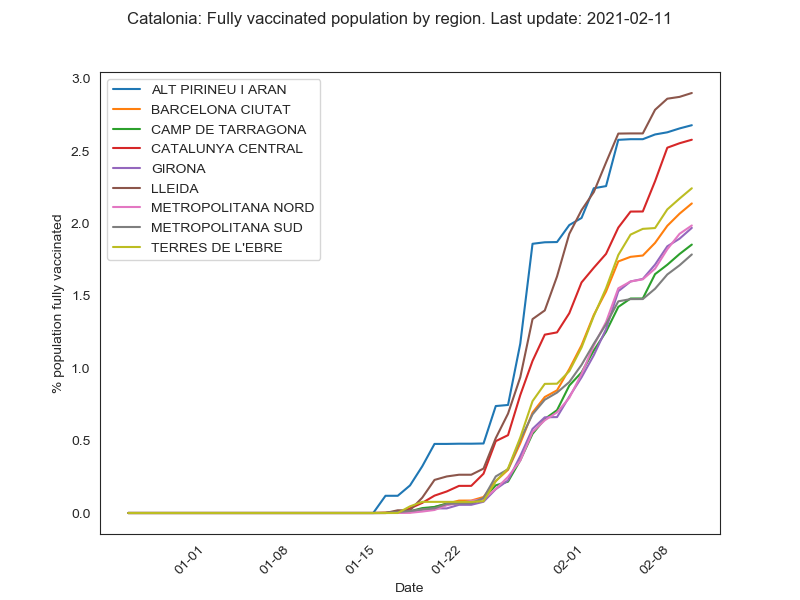

In [179]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle("Catalonia: Fully vaccinated population by region. Last update: " + max(dfaggvac["DATA"]).strftime("%Y-%m-%d"))
ax = sns.lineplot(x="DATA",y="2nd dose percent",data=dfregagg,hue="NOM",)
ax.set_xlabel("Date")
ax.set_ylabel("% population fully vaccinated")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.tick_params(axis="x",rotation=45)
plt.savefig('CurrentRegionVaccinationCat.png')